In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

# Intro - Loading and checking completeness


First, import our merged dataset with crime and demographic data.

Each row in this merged file represents *one* MSA in *one* of the years included for analysis. Columns are merged from the FBI Crime (normalized to population upstream; rate per 100,000 inhabitants) and ACS demographic databases.

In [2]:
all_df = pd.read_csv('data/derived/crime_ACS_merged.csv', low_memory=False)
print(all_df.shape)
all_df.columns  # [:20]

(3283, 564)


Index(['Unnamed: 0', 'Aggravated assault', 'Burglary',
       'Counties/principal cities', 'Larceny', 'Motor vehicle theft',
       'Murder and nonnegligent manslaughter', 'Population', 'Property crime',
       'Rape',
       ...
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1939 or earlier',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1940 to 1949',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1950 to 1959',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1960 to 1969',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1970 to 1979',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1980 to 1989',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1990 to 1999',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2000 to 2009',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2010 to 2013',
       'Percent; YEA

In [3]:
all_df.head(3)

,Unnamed: 0,Aggravated assault,Burglary,Counties/principal cities,Larceny,Motor vehicle theft,Murder and nonnegligent manslaughter,Population,Property crime,Rape,...,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1939 or earlier,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1940 to 1949,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1950 to 1959,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1960 to 1969,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1970 to 1979,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1980 to 1989,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1990 to 1999,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2000 to 2009,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2010 to 2013,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2014 or later
0,2,227.8,649.9,"Rate per 100,000 inhabitants",2077.9,175.4,6.5,NaN,2903.1,46.5,...,9.5,8.4,18.6,11.1,15.0,15.5,8.6,9.3,2.6,1.5
1,6,121.0,563.3,"Rate per 100,000 inhabitants",1857.3,144.0,6.0,NaN,2564.5,48.9,...,19.0,7.2,14.9,11.6,13.9,9.1,12.9,9.4,1.5,0.6
2,10,534.9,949.8,"Rate per 100,000 inhabitants",2676.9,144.2,11.8,NaN,3770.8,28.2,...,6.2,3.2,9.7,14.0,15.2,15.4,17.0,16.9,1.9,0.3


Next, we do some preliminary checks on our dataframe: How many observations per metropolitan area do we have in our dataset? Are the MSAs relatively stable or do they jump around over the ten years worth of data included in our merged dataframe?

[<matplotlib.text.Text at 0x112655e48>, <matplotlib.text.Text at 0x113ee80f0>]

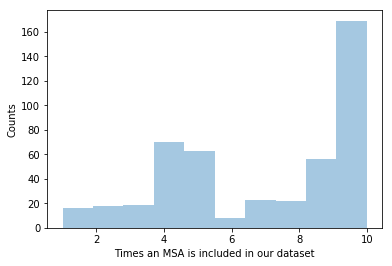

In [11]:
ax = sns.distplot(all_df['MSA'].value_counts(), kde=False, bins=10);
ax.set(xlabel='Times an MSA is included in our dataset', ylabel='Counts')

Most of the MSAs survive the merge across all ten years, but some seem to appear and disappear. Let's look at number of observations per year to check if any one year is particularly problematic:

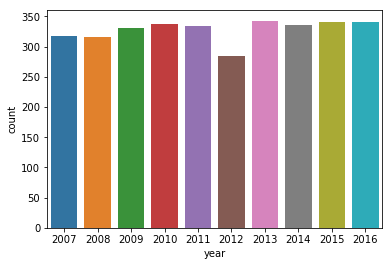

In [12]:
sns.countplot(x='year', data=all_df)

All ten years have a similar number of observations; nothing too problematic.

## Begining EDA - Basic Correlations

Before conducting any EDA, we will split our data into train and test sets. We will only perform EDA and all further analyses on the train set only, and use the test set only to assess our model fit at the end.

In [13]:
np.random.seed(42)
df_train, df_test = train_test_split(all_df, test_size=.3, stratify=all_df['year'])
print(df_train.shape)

(2298, 564)


### Crime data

Now, let's take a closer look at our crime data. The FBI site defines **violent crimes** as those offenses that involve force or threat of force. Violent crime is *composed* of four offenses: murder and nonnegligent manslaughter, rape, robbery, and aggravated assault. On the other hand, **property crime** includes the offenses of burglary, larceny-theft, motor vehicle theft, and arson. The object of the theft-type offenses is the taking of money or property, but there is no force or threat of force against the victims. 

In general, do crimes tend to cluster together? We would expect these relationships to be relatively high considering "safe" and "dangerous" neighborhoods.

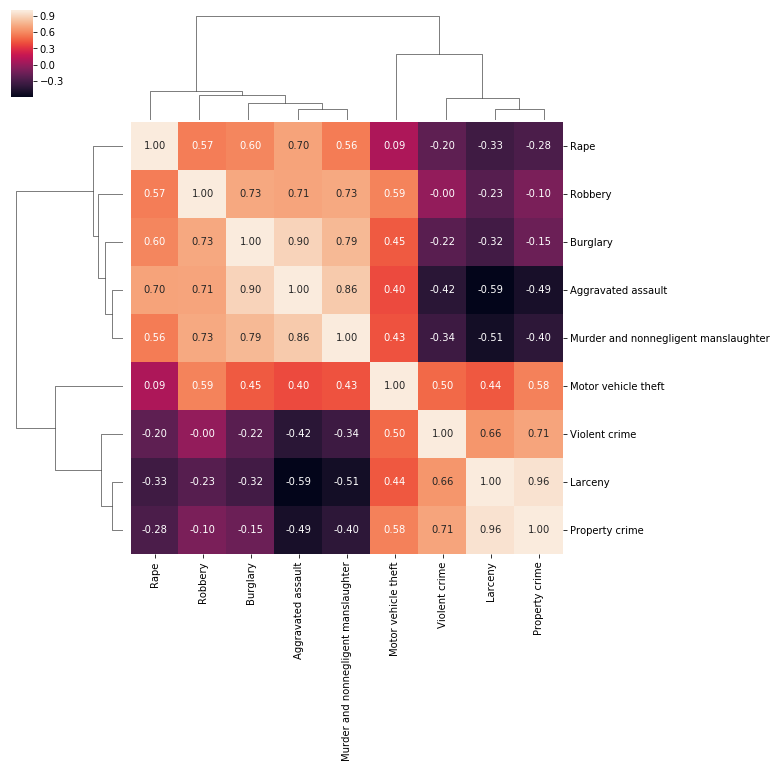

In [14]:
crime_columns = ['Aggravated assault', 'Burglary', 'Counties/principal cities', 'Larceny',
                 'Motor vehicle theft', 'Murder and nonnegligent manslaughter', 'Property crime', 
                 'Rape', 'Robbery', 'Violent crime']
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.clustermap(df_train[crime_columns].corr().dropna(), annot=True, fmt='.02f', square=True);

We first looked at the relationship between the crime counts themselves. Note that the plot (and our dataframe) includes both the two main crime categories (violent and property crime) as well as their respective subcomponents as separate columns. Not surprisingly, many of these crimes tend to occur to similar degrees.

For the specific purposes of this project and from here on out, we will focus on **murder and nonnegligent manslaughter** as our predicted variable of interest. 

### Murder rate

Let's take a quick look at murder rate distribution and how it varies by time and MSA.

#### What is the distribution of murder rate?

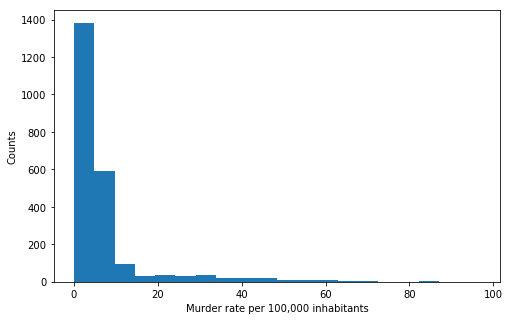

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.hist(df_train['Murder and nonnegligent manslaughter'].dropna(), bins=20)

ax.set_xlabel('Murder rate per 100,000 inhabitants')
ax.set_ylabel('Counts')

In [16]:
print("Lowest murder rate in our data:", min(df_train['Murder and nonnegligent manslaughter']))
print("Highest murder rate in our data:", max(df_train['Murder and nonnegligent manslaughter']))

Lowest murder rate in our data: 0.0
Highest murder rate in our data: 96.8


While some MSA murder rates get close to 20 per 100,000 inhabitants, most MSAs have a murder rate of about 5 per 100,000 inhabitants.

#### How does murder rate vary across time?

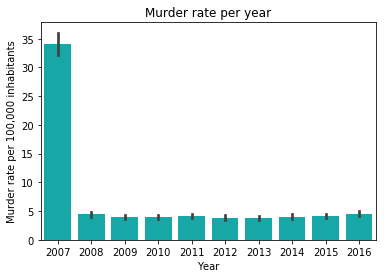

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

g = sns.barplot(x=df_train['year'] , y=df_train['Murder and nonnegligent manslaughter'], color = 'c')

ax.set_title('Murder rate per year')

ax.set_xlabel('Year')
ax.set_ylabel('Murder rate per 100,000 inhabitants')


Looking at rate of murders per year across all MSAs, we see that there was a steady rate around 5 murders per 100,000 inhabitants from 2007 to 2016, so there doesn't seem to be any drastic changes in murder rate across time in the period from 2007 to 2016.

#### How does murder rate vary by MSA?

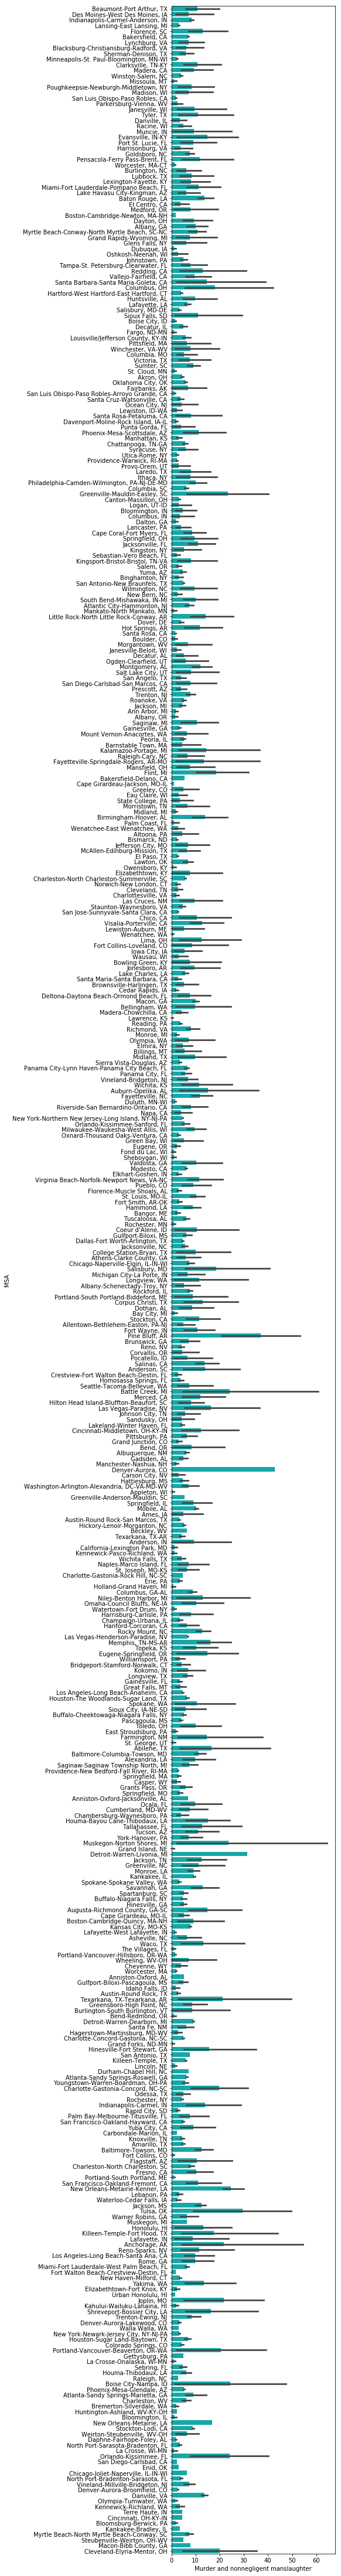

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 80))

sns.barplot(x=df_train['Murder and nonnegligent manslaughter'], y=df_train['MSA'], color = 'c')

Some MSAs with the highest murder rates are: **NEED TO FILL THIS IN ONCE WE HAVE CLEANED THE 2007 DATA**

#### How does murder rate vary by MSA population?

According to the literature reviewed, larger urban cities have higher crime rates. Is this so for murder rate in particular?

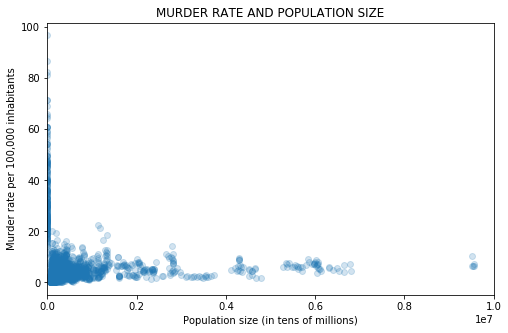

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

#there are some missing values for the population columns (marked as 'N'); replace with 'NaNs' so we can plot

ax.plot(df_train.loc[:,'Percent; ANCESTRY - Total population'].replace('N','NaN'),df_train['Murder and nonnegligent manslaughter'],'o',alpha = .2)

ax.set_xlim([0,10000000])

ax.set_title('MURDER RATE AND POPULATION SIZE')

ax.set_xlabel('Population size (in tens of millions)')
ax.set_ylabel('Murder rate per 100,000 inhabitants')

Contrary to what we'd expect, we don't see a clear trend between population size and murder rate.

### How do different demographic factors relate to murder rate?

#### Murder rate and age

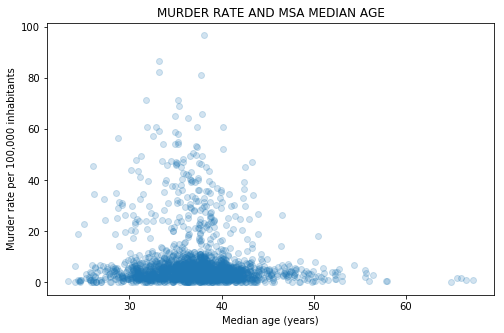

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(df_train['Estimate; SEX AND AGE - Median age (years)'], 
        df_train['Murder and nonnegligent manslaughter'], 'o', alpha=0.2)

ax.set_title('MURDER RATE AND MSA MEDIAN AGE')

ax.set_xlabel('Median age (years)')
ax.set_ylabel('Murder rate per 100,000 inhabitants')


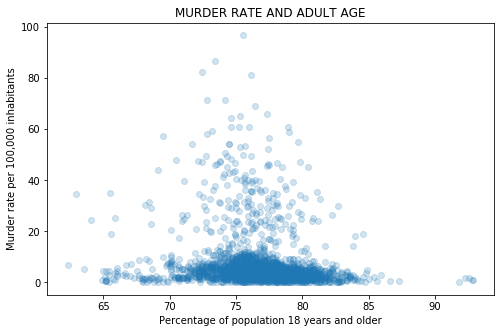

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(df_train['Percent; SEX AND AGE - 18 years and over'], 
        df_train['Murder and nonnegligent manslaughter'], 'o', alpha=0.2)

ax.set_title('MURDER RATE AND ADULT AGE')

ax.set_xlabel('Percentage of population 18 years and older')
ax.set_ylabel('Murder rate per 100,000 inhabitants')


Higher murder rates appear to be concentrated in MSAs were about 72-80% of the population are 18 years and older. MSAs with higher percentage of minors (smaller percentage of 18+ inhabitants) present lower murder rates.

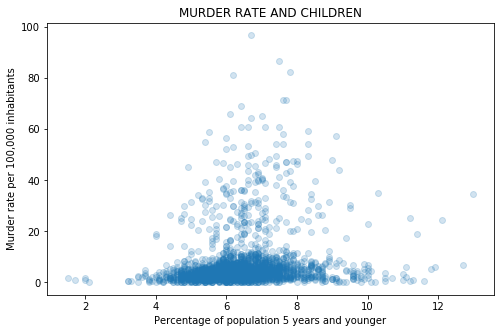

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(df_train['Percent; SEX AND AGE - Under 5 years'], 
        df_train['Murder and nonnegligent manslaughter'], 'o', alpha=0.2)

ax.set_title('MURDER RATE AND CHILDREN')

ax.set_xlabel('Percentage of population 5 years and younger')
ax.set_ylabel('Murder rate per 100,000 inhabitants')

#### Murder rate and gender

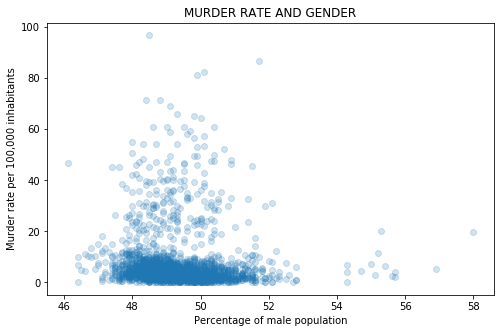

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(df_train['Percent; SEX AND AGE - Total population - Male'], 
        df_train['Murder and nonnegligent manslaughter'], 'o', alpha=0.2)

ax.set_title('MURDER RATE AND GENDER')

ax.set_xlabel('Percentage of male population')
ax.set_ylabel('Murder rate per 100,000 inhabitants')


The female:male ratio is pretty close to 1:1 for most MSAs, so the claims we can make regarding the relationship of murder rates and gender makeup are limited. The highest murder rates appear in the 48-52% male population MSAs.

#### Murder rate and income

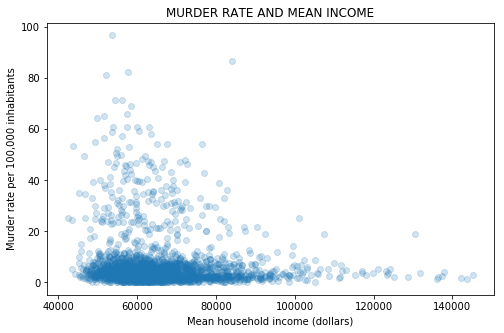

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(df_train['Estimate; INCOME AND BENEFITS (IN 2016 INFLATION-ADJUSTED DOLLARS) - Total households - Mean household income (dollars)'], 
        df_train['Murder and nonnegligent manslaughter'], 'o', alpha=0.2)

ax.set_title('MURDER RATE AND MEAN INCOME')

ax.set_xlabel('Mean household income (dollars)')
ax.set_ylabel('Murder rate per 100,000 inhabitants')


The highest murder rates are associated to MSAs with lower mean income.

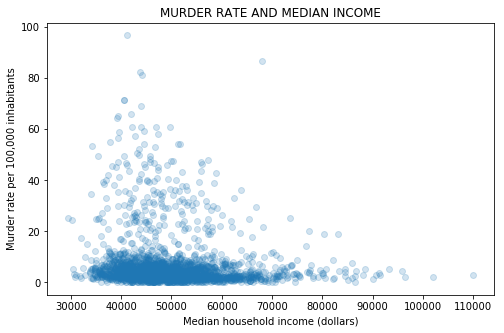

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(df_train['Estimate; INCOME AND BENEFITS (IN 2016 INFLATION-ADJUSTED DOLLARS) - Total households - Median household income (dollars)'], 
        df_train['Murder and nonnegligent manslaughter'], 'o', alpha=0.2)

ax.set_title('MURDER RATE AND MEDIAN INCOME')

ax.set_xlabel('Median household income (dollars)')
ax.set_ylabel('Murder rate per 100,000 inhabitants')


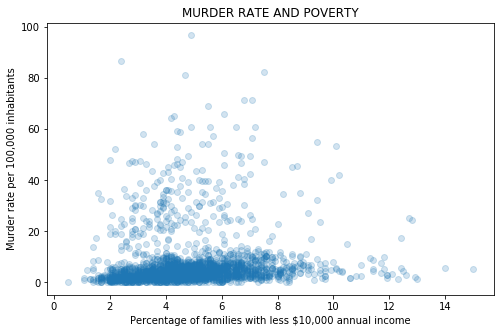

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(df_train['Percent; INCOME AND BENEFITS (IN 2016 INFLATION-ADJUSTED DOLLARS) - Families - Less than $10,000'], 
        df_train['Murder and nonnegligent manslaughter'], 'o', alpha=0.2)

ax.set_title('MURDER RATE AND POVERTY')

ax.set_xlabel('Percentage of families with less $10,000 annual income')
ax.set_ylabel('Murder rate per 100,000 inhabitants')


#### Murder rate and educational attainment

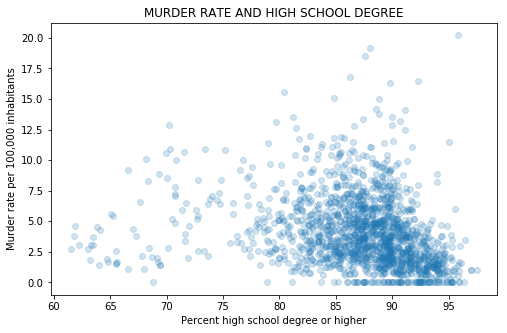

In [28]:
#murder and ed attainment plot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

#Some missing values for Educational attainment column for years 2007-2009 (marked as '(X)'; 
    #replace with 'NaNs' so we can plot

ax.plot(df_train["Percent; EDUCATIONAL ATTAINMENT - Percent high school graduate or higher"].replace('(X)','NaN'), 
        df_train['Murder and nonnegligent manslaughter'], 'o', alpha=0.2)

ax.set_title('MURDER RATE AND HIGH SCHOOL DEGREE')

ax.set_xlabel("Percent high school degree or higher")
ax.set_ylabel('Murder rate per 100,000 inhabitants')


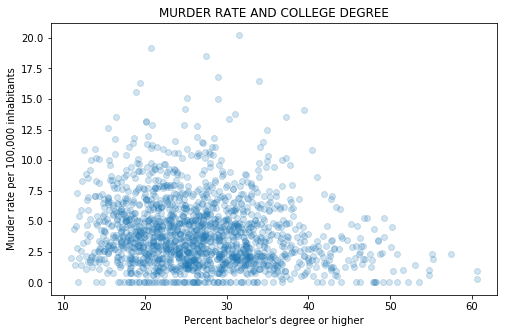

In [29]:
#murder and ed attainment plot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

#Some missing values for Educational attainment column for years 2007-2009 (marked as '(X)'; 
    #replace with 'NaNs' so we can plot

ax.plot(df_train["Percent; EDUCATIONAL ATTAINMENT - Percent bachelor's degree or higher"].replace('(X)','NaN'), 
        df_train['Murder and nonnegligent manslaughter'], 'o', alpha=0.2)

ax.set_title('MURDER RATE AND COLLEGE DEGREE')

ax.set_xlabel("Percent bachelor's degree or higher")
ax.set_ylabel('Murder rate per 100,000 inhabitants')


MSAs with lower percentage of inhabitants with a high school degree or higher present higher murder rates.

#### Murder rate and unemployment

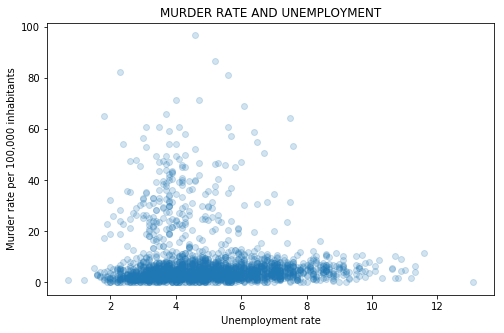

In [30]:
#murder and ed attainment plot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

#Some missing values for Educational attainment column for years 2007-2009 (marked as '(X)'; 
    #replace with 'NaNs' so we can plot

ax.plot(df_train.loc[:,"Percent; EMPLOYMENT STATUS - Population 16 years and over - In labor force - Civilian labor force - Unemployed"].replace('N','NaN'), 
        df_train['Murder and nonnegligent manslaughter'], 'o', alpha=0.2)

ax.set_title('MURDER RATE AND UNEMPLOYMENT')

ax.set_xlabel("Unemployment rate")
ax.set_ylabel('Murder rate per 100,000 inhabitants')


Surpringly, the higher murder rates appear in MSAs with lower unemployment rates.

## SUMMARY/CLOSING COMMENT HERE